In [1]:
!pip install langgraph langsmith langchain langchain_groq langchain_community

In [2]:
from typing import Annotated
from typing_extensions import TypedDict

In [3]:
!pip install arxiv wikipedia

  Obtaining dependency information for arxiv from https://files.pythonhosted.org/packages/b7/7b/7bf42178d227b26d3daf94cdd22a72a4ed5bf235548c4f5aea49c51c6458/arxiv-2.1.3-py3-none-any.whl.metadata
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Obtaining dependency information for feedparser~=6.0.10 from https://files.pythonhosted.org/packages/7c/d4/8c31aad9cc18f451c49f7f9cfb5799dadffc88177f7917bc90a66459b1d7/feedparser-6.0.11-py3-none-any.whl.metadata
  Obtaining dependency information for requests~=2.32.0 from https://files.pythonhosted.org/packages/f9/9b/335f9764261e915ed497fcdeb11df5dfd6f7bf257d4a6a2a686d80da4d54/requests-2.32.3-py3-none-any.whl.metadata
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/81.3 kB ? eta -:--:--
   ---------------------------------------- 81.3/81.3 kB 4.7 MB/s eta 0:00:00
   --------------------------

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
conda-repo-cli 1.0.75 requires requests_mock, which is not installed.
anaconda-cloud-auth 0.1.3 requires pydantic<2.0, but you have pydantic 2.10.6 which is incompatible.
conda-repo-cli 1.0.75 requires clyent==1.2.1, but you have clyent 1.2.2 which is incompatible.
conda-repo-cli 1.0.75 requires PyYAML==6.0.1, but you have pyyaml 6.0 which is incompatible.
conda-repo-cli 1.0.75 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.


In [4]:
## Working With Tools

from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun

## Arxiv And Wikipedia tools
arxiv_wrapper=ArxivAPIWrapper(top_k_results=1,doc_content_chars_max=300)
arxiv_tool=ArxivQueryRun(api_wrapper=arxiv_wrapper)

api_wrapper=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=300)
wiki_tool=WikipediaQueryRun(api_wrapper=api_wrapper)

In [5]:
wiki_tool.invoke("who is Sharukh Khan")

'Page: Shah Rukh Khan\nSummary: Shah Rukh Khan (pronounced [ˈʃaːɦɾʊx xäːn] ; born 2 November 1965), also known by the initialism SRK, is an Indian actor and film producer who works in Hindi cinema. Referred to in the media as the "Baadshah of Bollywood" and "King Khan", he has appeared in more than 10'

In [6]:
arxiv_tool.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with "

In [7]:
tools=[wiki_tool]

In [8]:
## Langgraph Application
from langgraph.graph.message import add_messages
class State(TypedDict):
  messages:Annotated[list,add_messages]

In [9]:
from langgraph.graph import StateGraph,START,END

In [10]:
graph_builder= StateGraph(State)

In [11]:
from langchain_groq import ChatGroq

In [14]:
import os
from dotenv import load_dotenv
load_dotenv()
groq_api_key=os.environ["GROQ_API_KEY"]="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"
langsmith=os.environ["LANGSMITH_API_KEY"]="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"

In [15]:
print(groq_api_key)
print(langsmith)

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
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


In [16]:
llm=ChatGroq(groq_api_key="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",model_name="Gemma2-9b-It")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x00000130ECDD2190>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x00000130ECDE0590>, model_name='Gemma2-9b-It', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [17]:
llm_with_tools=llm.bind_tools(tools=tools)

In [18]:
def chatbot(state:State):
  return {"messages":[llm_with_tools.invoke(state["messages"])]}

In [19]:
from langgraph.prebuilt import ToolNode,tools_condition

In [20]:
graph_builder.add_node("chatbot",chatbot)
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START,"chatbot")

In [21]:
graph=graph_builder.compile()

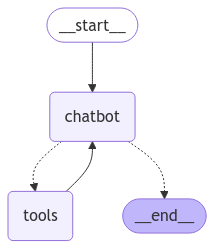

In [22]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [25]:
user_input="Hi there!, My name is John"

events=graph.stream(
     {"messages": [("user", user_input)]},stream_mode="values"
)

for event in events:
  event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there!, My name is John
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_5fhp)
 Call ID: call_5fhp
  Args:
    query: John


C:\Users\arkop\anaconda3\Lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file C:\Users\arkop\anaconda3\Lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


================================= Tool Message =================================
Name: wikipedia

No good Wikipedia Search Result was found
================================== Ai Message ==================================

It seems like there isn't much information about a person named John on Wikipedia. Would you like to try a different name or search term?


In [24]:
user_input = "what is RLHF."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]},stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

what is RLHF.
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_ym8f)
 Call ID: call_ym8f
  Args:
    query: RLHF
================================= Tool Message =================================
Name: wikipedia

Page: Reinforcement learning from human feedback
Summary: In machine learning, reinforcement learning from human feedback (RLHF) is a technique to align an intelligent agent with human preferences. It involves training a reward model to represent preferences, which can then be used to train other mo
================================== Ai Message ==================================

Reinforcement learning from human feedback (RLHF) is a technique to align an intelligent agent with human preferences. It involves training a reward model to represent preferences, which can then be used to train other models to behave in ways that are desirable